In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [3]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [4]:
df_india = df[df['Country']=='India']

In [5]:
df_india.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2613 entries, 243695 to 246307
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2613 non-null   object 
 1   AverageTemperature             2508 non-null   float64
 2   AverageTemperatureUncertainty  2508 non-null   float64
 3   Country                        2613 non-null   object 
dtypes: float64(2), object(2)
memory usage: 102.1+ KB


In [6]:
df_india = df_india.dropna()

In [7]:
df_india['dt'] = pd.to_datetime(df_india['dt'])

In [8]:
df_india.index = df_india.dt

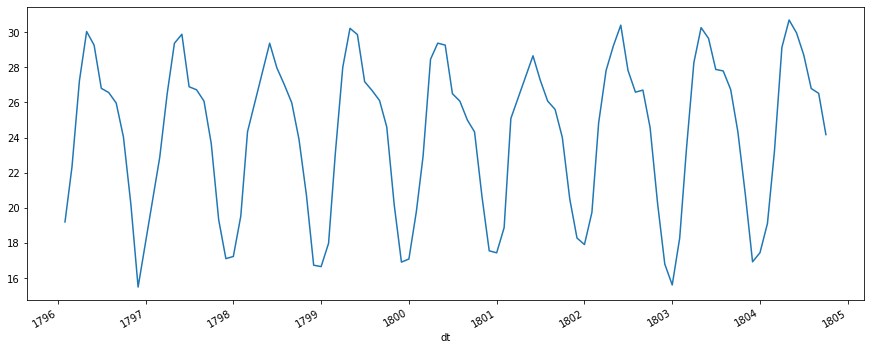

In [9]:
df_india['AverageTemperature'][1:100].plot(figsize=(15,6))

In [10]:
dtt = df_india[['AverageTemperature']]

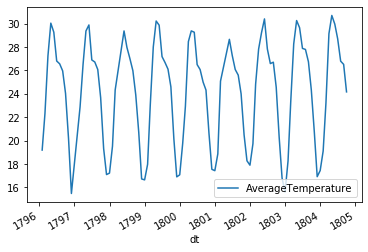

In [11]:
dtt[1:100].plot()

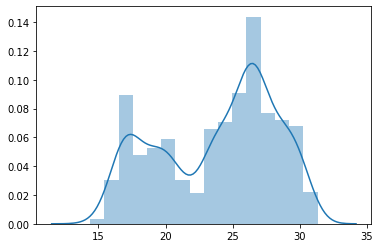

In [12]:
sns.distplot(dtt)

In [13]:
ds = dtt.resample('M').mean().dropna()

In [14]:
dy = dtt.resample('Y').mean().dropna()

In [15]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2508 entries, 1796-01-31 to 2013-08-31
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AverageTemperature  2508 non-null   float64
dtypes: float64(1)
memory usage: 39.2 KB


In [16]:
dy

,AverageTemperature
dt,
1796-12-31,23.675250
1797-12-31,24.839900
1798-12-31,23.273300
1799-12-31,23.949417
1800-12-31,23.911917
...,...
2009-12-31,25.146667
2010-12-31,25.050833
2011-12-31,24.415583


# Decomposition of Monthly sampled data series

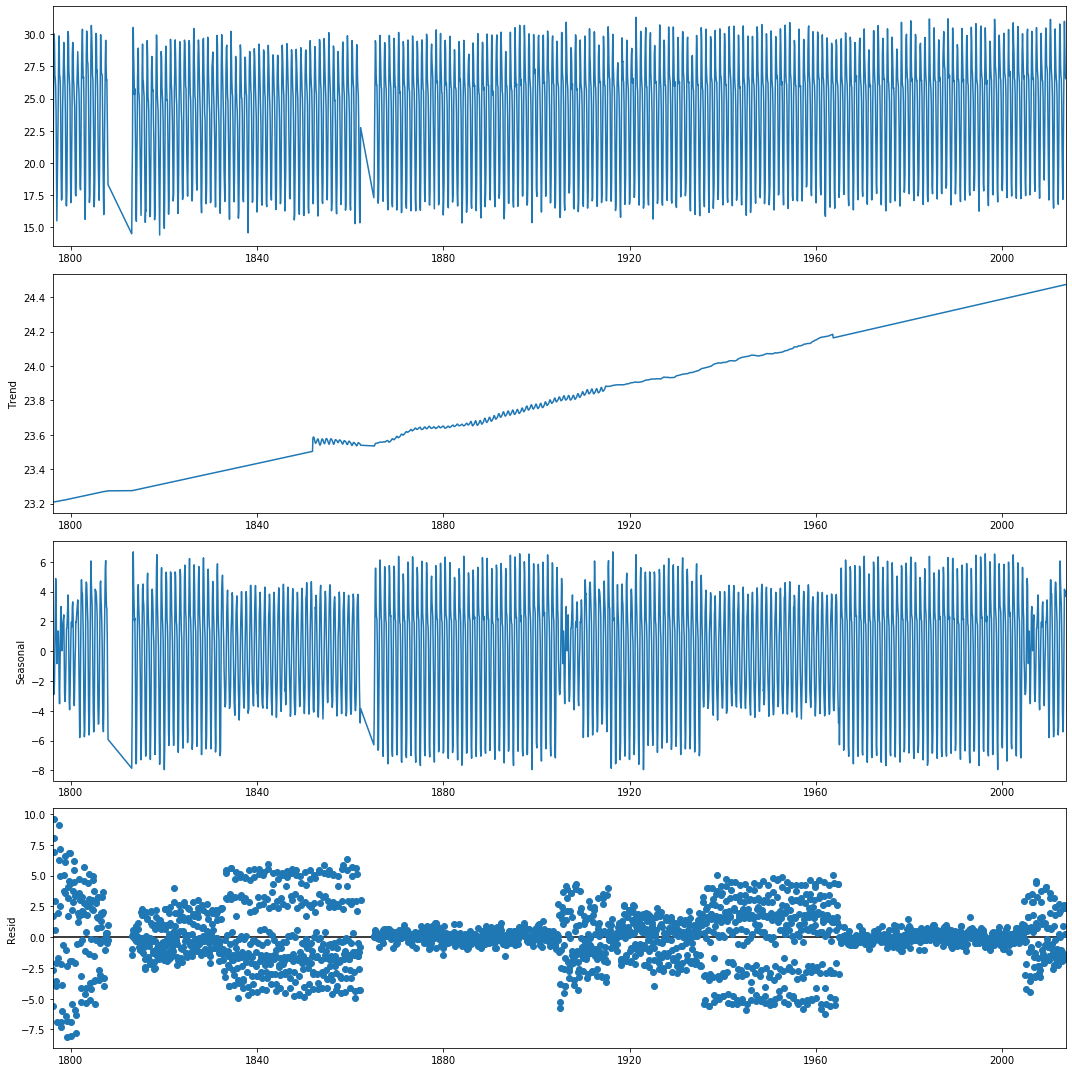

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(x=ds, model='additive', extrapolate_trend='freq', period=1200)
plt.rcParams.update({'figure.figsize': (15,15)})
decomp.plot()
plt.show()

# Test of stationarity of monthly sampled data series

In [18]:
from statsmodels.tsa.stattools import adfuller, kpss
def adf_test(x):
    indices = ['Test Statistic', 'p-value','# of Lags Used',
             '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results

In [19]:
adf_test(ds)

Test Statistic              -4.558478
p-value                      0.000154
# of Lags Used              26.000000
# of Observations Used    2481.000000
Critical Value (1%)         -3.432988
Critical Value (5%)         -2.862706
Critical Value (10%)        -2.567391
dtype: float64

In [20]:
def kpss_test(x, h0_type='c'):
    indices=['Test Statistic', 'p-value','# of Lags']
    kpss_test = kpss(x,regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results

In [21]:
kpss_test(ds)

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


Test Statistic            2.580487
p-value                   0.010000
# of Lags                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

# Decomposition of yearly sampeled data series

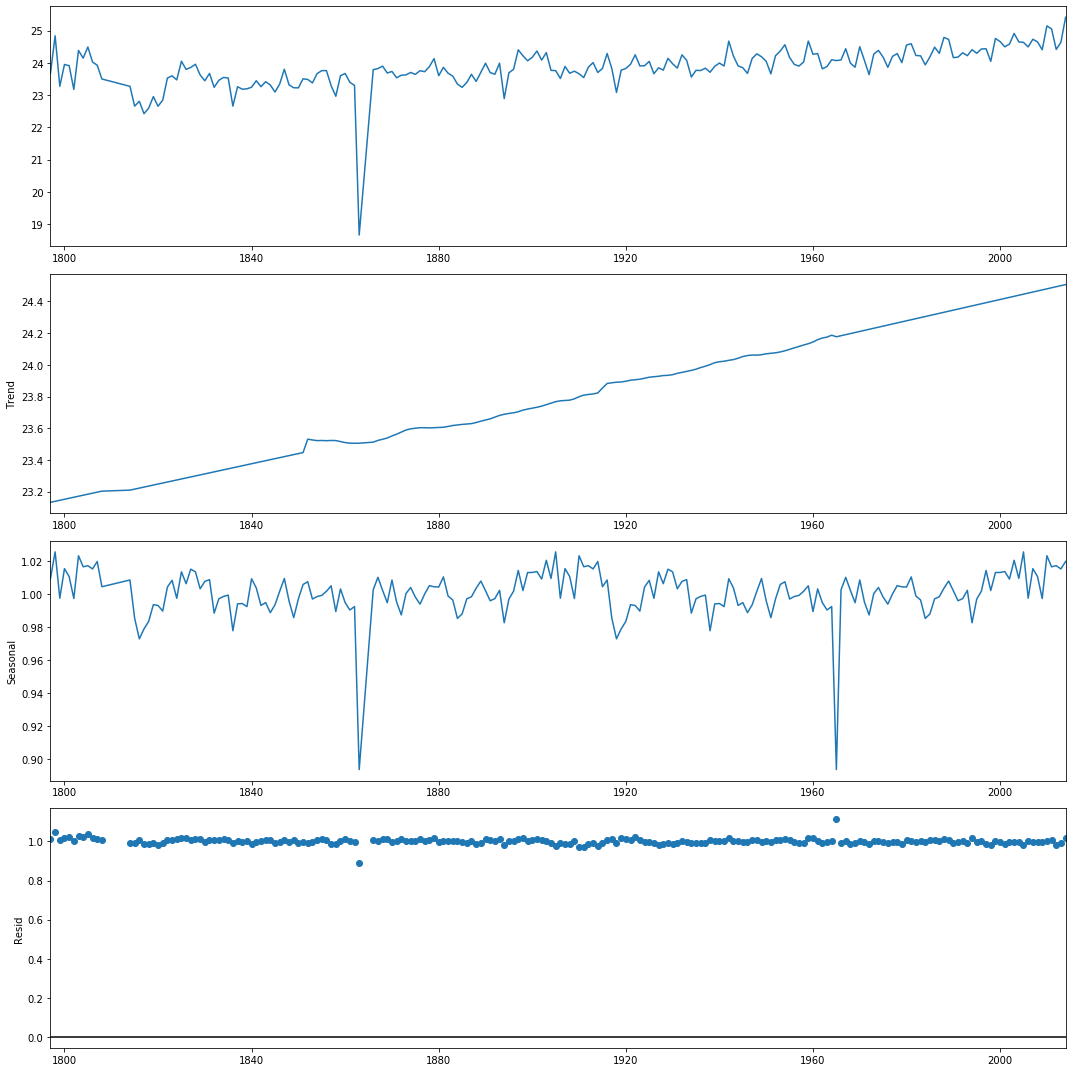

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(x=dy, model='multiplicative', extrapolate_trend='freq', period=100)
plt.rcParams.update({'figure.figsize': (15,15)})
decomp.plot()
plt.show()

# ACF and PACF plots

<Figure size 1080x216 with 0 Axes>

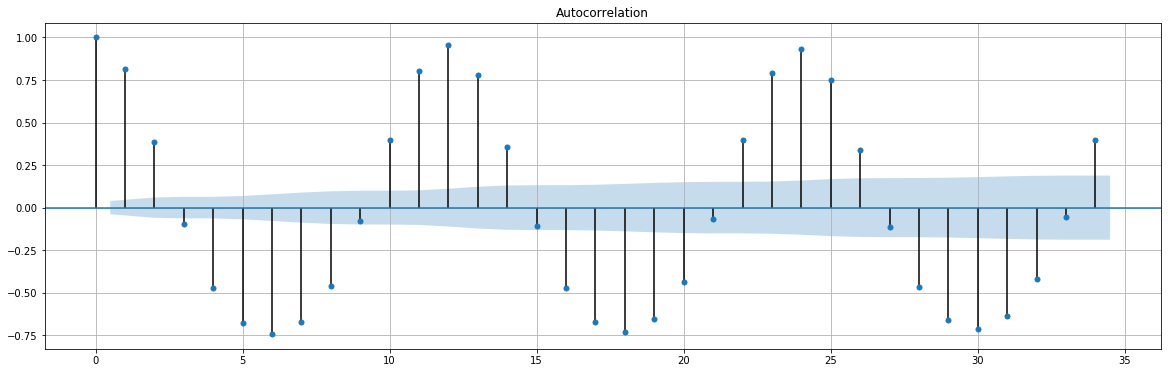

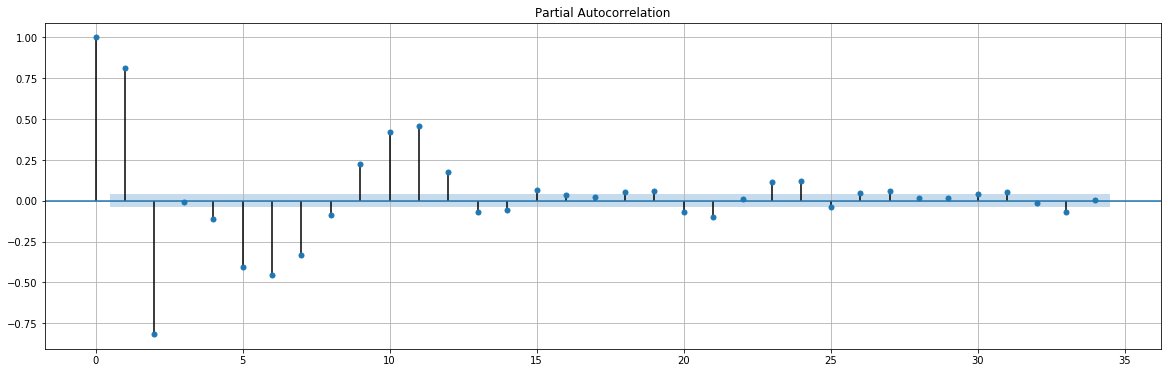

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams["figure.figsize"] = (20,6)
plt.figure(figsize=(15,3))
plot_acf(ds)
plt.grid()
plot_pacf(ds)
plt.grid()
plt.show()

In [24]:
ds

,AverageTemperature
dt,
1796-01-31,17.044
1796-02-29,19.193
1796-03-31,22.319
1796-04-30,27.233
1796-05-31,30.035
...,...
2013-04-30,27.981
2013-05-31,31.014
2013-06-30,28.766


# Train Test Split

In [25]:
train = ds[:2000]
test = ds[2000:]

# Building the Seasonal Arima Model

In [26]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=6,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 6); AIC=7994.162, BIC=8022.152, Fit time=3.960 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 6); AIC=14022.994, BIC=14034.190, Fit time=0.160 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 6); AIC=5918.430, BIC=5940.822, Fit time=3.755 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 6); AIC=9408.963, BIC=9431.354, Fit time=3.517 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 6); AIC=11414.496, BIC=11431.290, Fit time=0.437 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 6); AIC=5916.678, BIC=5944.668, Fit time=6.310 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 6); AIC=5903.744, BIC=5937.331, Fit time=8.982 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 6); AIC=6448.968, BIC=6476.957, Fit time=9.748 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 1, 6); AIC=5861.909, BIC=5901.094, Fit time=11.111 seconds
Fit ARIMA: order=(2, 0, 1) seaso

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 2000
Model:             SARIMAX(3, 0, 3)x(1, 1, [1, 2], 6)   Log Likelihood               -2631.249
Date:                                Sun, 14 Feb 2021   AIC                           5284.497
Time:                                        00:38:58   BIC                           5346.074
Sample:                                             0   HQIC                          5307.111
                                               - 2000                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.003     -0.112      0.910      -0.007       0.006
ar.L1          1.9837      0.060     32.789      0.000       1.865       2.102
ar.L2         -1.4523      0.102    -14.192      0.000      -1.653      -1.252
ar.L3          0.2705      0.059      4.618      0.000       0.156       0.385
ma.L1         -1.2753      0.059    -21.584      0.000      -1.391      -1.160
ma.L2          0.3811      0.071      5.330      0.000       0.241       0.521
ma.L3          0.1673      0.031      5.440      0.000       0.107       0.228
ar.S.L6       -0.9928      0.004   -266.874      0.000      -1.000      -0.985
ma.S.L6        0.2355      0.017     13.799      0.000       0.202       0.269
ma.S.L12      -0.6817      0.016    -41.880      0.000      -0.714      -0.650
sigma2         0.8116      0.011     72.001      0.000       0.789       0.834
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):             10945.74
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
pre_res, conif = smodel.predict(n_periods=800, return_conf_int=True)

In [28]:
index_of_fc = pd.date_range(train.index[-1], periods = 800, freq='MS')

In [29]:
fitted_series = pd.Series(pre_res, index=index_of_fc)
lower_series = pd.Series(conif[:, 0], index=index_of_fc)
upper_series = pd.Series(conif[:, 1], index=index_of_fc)

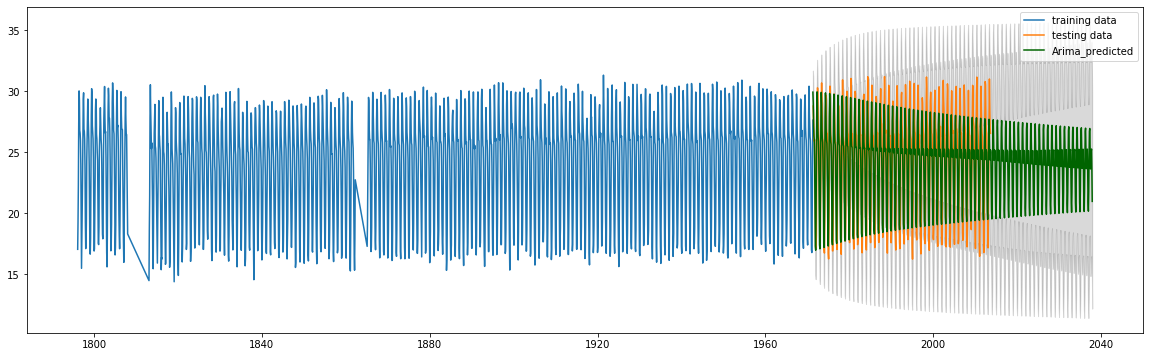

In [30]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(train, label='training data')
plt.plot(test, label='testing data')
plt.plot(fitted_series, color='darkgreen', label='Arima_predicted')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend()

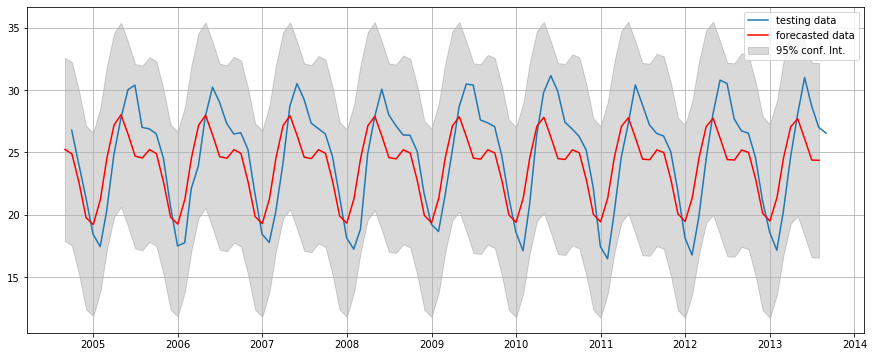

In [31]:
plt.figure(figsize=(15,6))
plt.plot(test[400:508], label='testing data')
plt.plot(fitted_series[400:508],'r',label='forecasted data')
plt.fill_between(lower_series[400:508].index, 
                 lower_series[400:508], 
                 upper_series[400:508], 
                 color='k', alpha=.15, label='95% conf. Int.')
plt.legend()

plt.grid()

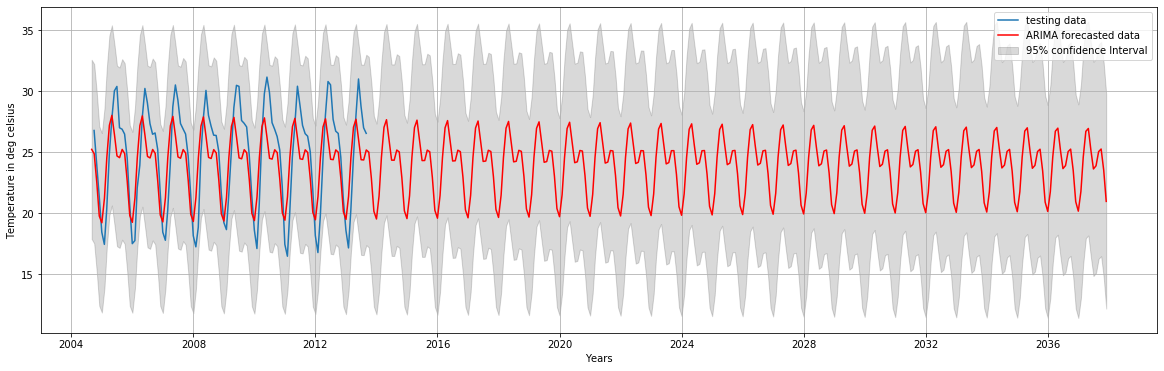

In [32]:
plt.plot(test[400:508], label='testing data')
plt.plot(fitted_series[400:],'r', label='ARIMA forecasted data')
plt.fill_between(lower_series[400:].index, 
                 lower_series[400:], 
                 upper_series[400:], 
                 color='k', alpha=.15, label='95% confidence Interval')
plt.xlabel('Years')
plt.ylabel('Temperature in deg celsius')
plt.legend()
plt.grid()

In [33]:
fitted_series

1971-05-01    29.935686
1971-06-01    29.067616
1971-07-01    27.151186
1971-08-01    26.327682
1971-09-01    25.990921
                ...    
2037-08-01    23.895391
2037-09-01    25.055388
2037-10-01    25.269456
2037-11-01    23.530258
2037-12-01    20.976453
Freq: MS, Length: 800, dtype: float64

In [34]:
import scipy.stats as scs
import statsmodels.api as sm

In [35]:
def arima_diagnose(resids, n_lags=40):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,8))
    r=resids
    resids = (r-np.nanmean(r))/np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    sns.lineplot(x=np.arange(len(resids)), y = resids, ax=ax1)
    ax1.set_title('Standardized residuals')
    x_lim = (-1.96*2, 1.96*2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.distplot(resids_nonmissing, hist=True, kde=True, norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of Standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')
    return fig

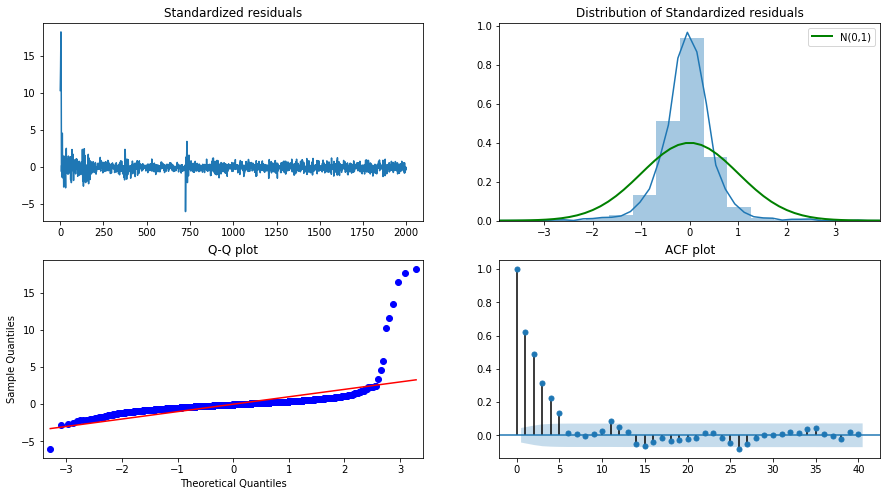

In [36]:
arima_diagnose(smodel.resid(),40)
plt.show()

In [37]:
from arch.unitroot import PhillipsPerron
pp = PhillipsPerron(ds)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -11.011
P-value                         0.000
Lags                               27
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [38]:
from arch.unitroot import KPSS
kpss = KPSS(ds)
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  2.157
P-value                         0.000
Lags                               66
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
